Ok so the want here is to do a copule of things with the map. Specifically:

- Bring in the Zillow data
- Map rents across NYC
- Layer on a subway map?

In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt # Helps plot
import numpy as np # Numerical operations

import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.colors as colors

#import fiona # Needed for geopandas to run
import geopandas as gpd # this is the main geopandas 
#from shapely.geometry import Point, Polygon # also needed


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
os.getcwd() + "\\zillow\\zillow_med_price"


'C:\\Users\\mwaugh\\github\\data_bootcamp_spring_2019\\mapping\\zillow\\zillow_med_price'

In [4]:
df = pd.read_csv(os.getcwd() + "\\zillow\\Zip_ZriPerSqft_AllHomes.csv",encoding = "ISO-8859-1")

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3.946,3.910,3.866,...,4.338,4.336,4.336,4.338,4.350,4.386,4.426,4.462,4.486,4.508
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1.560,1.560,1.548,...,1.780,1.780,1.780,1.782,1.784,1.784,1.776,1.766,1.752,1.746
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,4.736,4.774,4.784,...,5.180,5.170,5.168,5.170,5.186,5.238,5.298,5.350,5.376,5.398
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,0.816,0.816,0.814,...,0.816,0.816,0.816,0.814,0.814,0.808,0.802,0.794,0.792,0.792
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,1.712,1.712,1.698,...,1.950,1.948,1.948,1.948,1.948,1.944,1.932,1.918,1.904,1.898


One thing about the zillow dataset is that is what I would call "wide" in the sense that there are many columns, and most of these reflect the same obsrvation unit, but just different time periods. For a lot of reasons, it makes for sense to make this dataframe "long" in the sense that each row reflects a observation (place,time,value).

Below is one way to do this by "melting it"

In [6]:
df = df.melt(id_vars = ["RegionID","RegionName","City","State","Metro","CountyName","SizeRank"
])

In [7]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,variable,value
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,2010-11,3.946
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,2010-11,1.560
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,2010-11,4.736
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,2010-11,0.816
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,2010-11,1.712


Now what we have is a "long data set" where each row is a place, time, value. This facilitaties our ability to select on stuff

In [8]:
nyc_price = df[(df.City == "New York") & (df.variable == "2019-01")].copy()

In [9]:
nyc_price.shape

(164, 9)

In [10]:
nyc_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,variable,value
1505770,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,2019-01,4.462
1505772,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,2019-01,5.350
1505778,61616,10002,New York,NY,New York-Newark-Jersey City,New York County,9,2019-01,5.150
1505779,61807,10467,New York,NY,New York-Newark-Jersey City,Bronx County,10,2019-01,1.310
1505780,62037,11226,New York,NY,New York-Newark-Jersey City,Kings County,11,2019-01,1.606


In [11]:
nyc_price["ZIPCODE"] = nyc_price.RegionName.astype(int)

new_name_dict = {"value": "price"}

nyc_price.rename(columns= new_name_dict, inplace=True)

nyc_price["log_price"] = np.log(nyc_price.price)

In [12]:
cwd = os.getcwd()

regions_shape = cwd + "\\shapefile\\ZIP_CODE_040114.shx"

regions_shape

nyc_map = gpd.read_file(regions_shape)

nyc_map.ZIPCODE = nyc_map.ZIPCODE.astype(int) # we want these to look like numbers

In [13]:
nyc_map  = nyc_map.merge(nyc_price, on='ZIPCODE', how = "left", indicator = True)

In [14]:
nyc_map.price.replace(np.nan,0.0, inplace = True)

In [15]:
nyc_map.tail()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,RegionName,City,State,Metro,CountyName,SizeRank,variable,price,log_price,_merge
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,...,10310.0,New York,NY,New York-Newark-Jersey City,Richmond County,6055.0,2019-01,1.570,0.451076,both
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,...,11693.0,New York,NY,New York-Newark-Jersey City,Queens County,8134.0,2019-01,1.996,0.691145,both
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,...,11249.0,New York,NY,New York-Newark-Jersey City,Kings County,1786.0,2019-01,3.598,1.280378,both
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,left_only
262,10119,1,New York,0.0,1.263930e+05,NY,New York,36,061,http://www.usps.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,left_only


C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


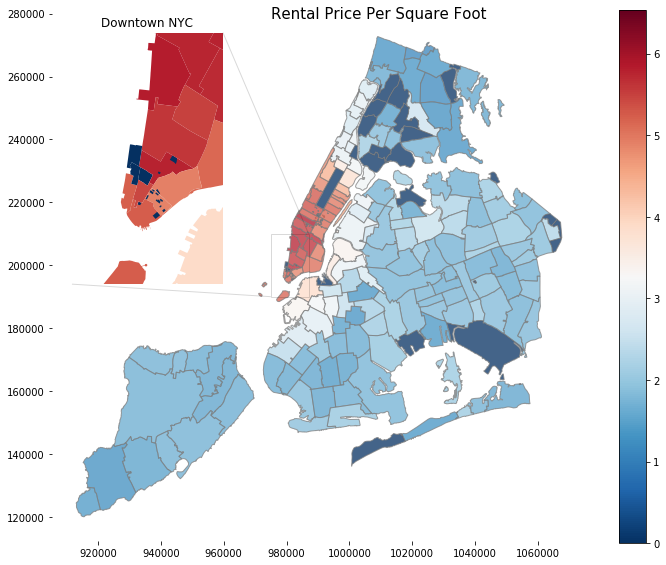

In [80]:
fig, ax = plt.subplots(figsize = (10,8))
plt.tight_layout()

# First create the map for the urban share

nyc_map.plot(ax = ax, edgecolor='tab:grey',
             column='price', # THIS IS NEW, it says color it based on this column
             cmap='RdBu_r', # This is the color map scheme https://matplotlib.org
             #/examples/color/colormaps_reference.html
             alpha = 0.75, vmin=0, vmax=1.1*nyc_price.price.max(), legend=True)

#subway.plot(ax = ax, color = 'k', alpha = 0.5)

#ax.get_xaxis().set_visible(False)

#ax.get_yaxis().set_visible(False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

fig.suptitle("Rental Price Per Square Foot", fontsize = 15)

########################################################################################

axins = zoomed_inset_axes(ax, # The original ax
                          4, # zoom level
                          loc=2, # location
                          borderpad=2)  # space around it relative to figure

nyc_map.plot(ax = axins, column='price', cmap='RdBu_r',
             vmin=0, vmax=1.1*nyc_price.price.max())

# Then create the map in the "insice ax" or axins. Note, that you do not
# need to keep the colering or the income, you could have the inset 
# be population or what ever else.

# then the stuff below picks the box for the inset to cover. I
# I kind of just eyballed this untill I zoomed into what I wanted

# Note the "axins" object really just works like the ax

x1, x2, y1, y2 = 975000, 987000, 190000, 210000
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.set_title("Downtown NYC")
# Make a title.

mark_inset(ax, axins, loc1=3, loc2=1, alpha = 0.15)
# This then creates the lines that marks where the inset comes from

# Make it look nice
axins.spines["right"].set_visible(False)
axins.spines["top"].set_visible(False)
axins.spines["left"].set_visible(False)
axins.spines["bottom"].set_visible(False)

#axins.Tick.remove()

axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)


plt.show()

In [16]:
cwd = os.getcwd()

subway_shape = cwd + "\\shapefile\\geo_export_ff76e398-04a7-40d7-b073-109c7324632d.shx"

regions_shape

subway = gpd.read_file(subway_shape)

In [17]:
subway.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,LINESTRING (-73.99487524803018 40.680203546062...
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,LINESTRING (-73.97957543205142 40.659930695530...
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,LINESTRING (-73.97585637503069 40.575974505394...
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,LINESTRING (-73.92414355434533 40.752290926571...
4,2000296.0,M,757.0,B,2385.698536,http://web.mta.info/nyct/service/,LINESTRING (-73.91344685471373 40.756171576368...


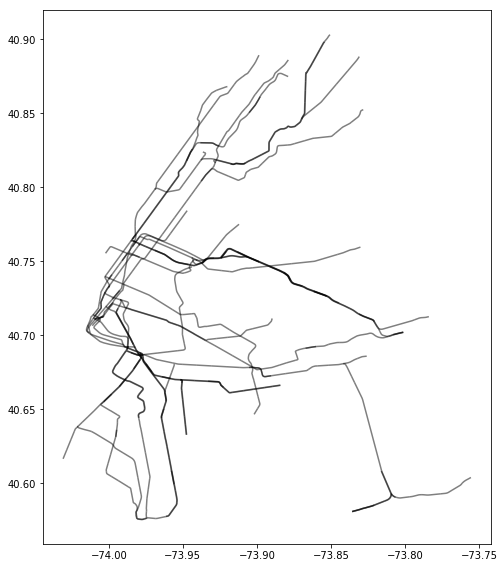

In [18]:
fig, ax = plt.subplots(figsize = (10,8))
plt.tight_layout()

# First create the map for the urban share

subway.plot(ax = ax, color = 'k', alpha = 0.5)

In [19]:
subway.crs

{'init': 'epsg:4326'}

In [20]:
nyc_map.crs

{'proj': 'lcc',
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [21]:
test = nyc_map.to_crs({'init': 'epsg:4326'})

In [39]:
test.COUNTY

0        Queens
1         Kings
2         Kings
3         Kings
4         Kings
5         Kings
6         Kings
7         Kings
8         Kings
9         Kings
10        Bronx
11        Bronx
12        Bronx
13        Bronx
14        Bronx
15        Bronx
16        Bronx
17        Bronx
18        Bronx
19     New York
20        Bronx
21     New York
22     New York
23        Bronx
24     New York
25        Bronx
26        Bronx
27        Bronx
28        Bronx
29        Bronx
         ...   
233    New York
234    New York
235    New York
236    New York
237    New York
238    New York
239    New York
240    New York
241    New York
242    New York
243    New York
244    New York
245    New York
246    New York
247    New York
248    New York
249    New York
250    New York
251    New York
252    New York
253    New York
254      Queens
255      Queens
256    New York
257      Queens
258    Richmond
259       Kings
260       Kings
261    New York
262    New York
Name: COUNTY, Length: 26

In [33]:
test_nyc_map = nyc_map.to_crs({'init': 'epsg:3395'})
test_subway = subway.to_crs({'init': 'epsg:3395'})

# This converts the geometry to a mercator projection. We had two problems, one was 

In [42]:
just_man = test_nyc_map[test_nyc_map.COUNTY == "New York"]

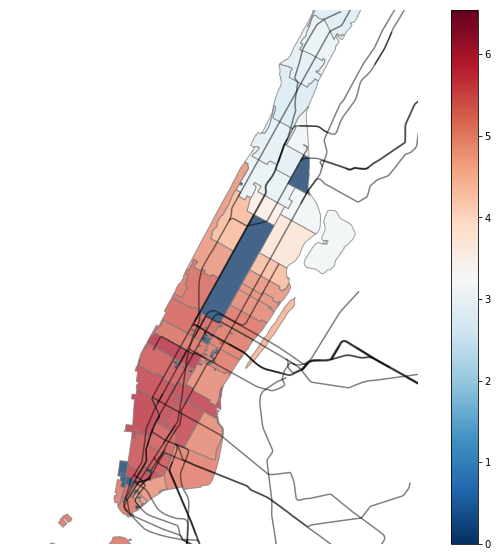

In [54]:
fig, ax = plt.subplots(figsize = (10,8))
plt.tight_layout()

# First create the map for the urban share

just_man.plot(ax = ax, edgecolor='tab:grey',
             column='price', # THIS IS NEW, it says color it based on this column
             cmap='RdBu_r', # This is the color map scheme https://matplotlib.org
             #/examples/color/colormaps_reference.html
             alpha = 0.75, vmin=0, vmax=1.1*test.price.max(), legend=True)

test_subway.plot(ax = ax, color = 'k', alpha = 0.5)

x1, x2, y1, y2 = -8245000, -8225000, 4939000, 4965000

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

#fig.suptitle("Rental Price Per Square Foot", fontsize = 15)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

########################################################################################


plt.show()